In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import sqlite3

# Load the true positive predictions from the CSV file
conn = sqlite3.connect('../../../../data/nfp2/nfp2.db')  # Adjust the path to your database file

# Step 2 & 3: Query the database and load the data into a pandas DataFrame
query = "SELECT * FROM stellarators"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)



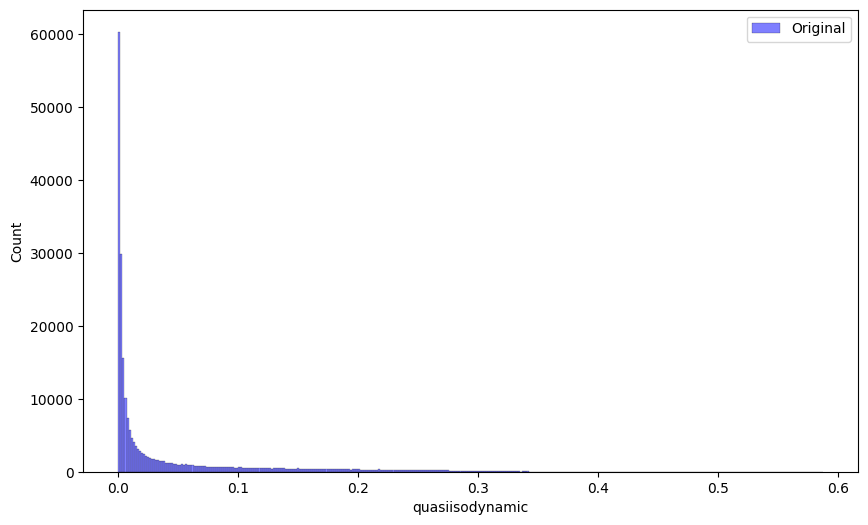

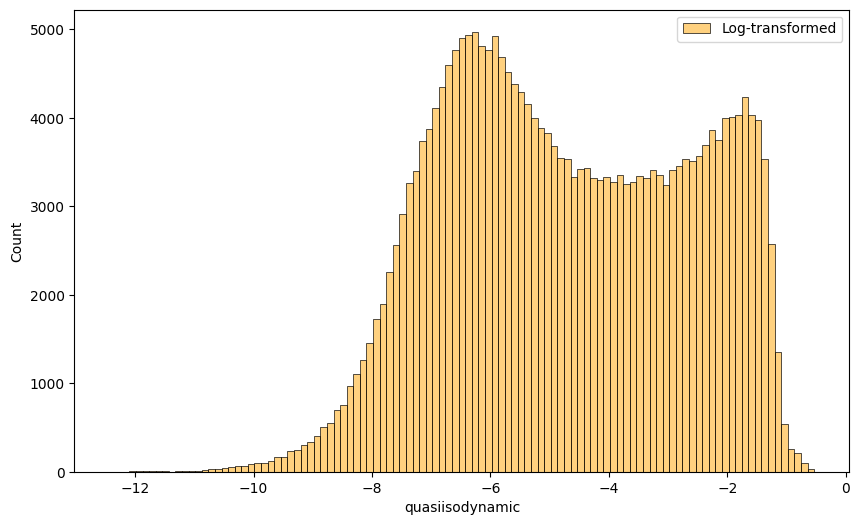

In [2]:
data_df_clean = data_df[data_df['convergence'] == 1]
data_df_clean = data_df_clean.dropna(subset=['quasiisodynamic'])


X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = np.log(data_df_clean['quasiisodynamic'])


#plot the distribution with and without log
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(data_df_clean['quasiisodynamic'], color="blue", alpha=0.5, label="Original")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(Y, color="orange", alpha=0.5, label="Log-transformed") 
plt.legend()
plt.show()

# Split the data into training and testing sets
features_no_outliers, test_features_no_outliers, target_no_outliers, test_target_no_outliers = train_test_split(X, Y, test_size=0.2, random_state=42)

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
best_params_manual = {
    'boosting_type': 'gbdt',
    'max_depth': 78,
    'num_leaves': 3637,
    'min_data_in_leaf': 1389,
    'feature_fraction': 0.9802098089739326,
    'learning_rate': 0.16418446321483615,
    'num_iterations': 696,
    'data_sample_strategy': 'bagging',
    'max_bins': 1640,
    'tree_learner': 'feature'
}

# Create and train the LightGBM model with the manually defined best parameters
model = lgb.LGBMRegressor(**best_params_manual)

# Assuming features_no_outliers and target_no_outliers are your feature matrix and target vector, respectively
model.fit(features_no_outliers, target_no_outliers)

model.booster_.save_model('lightgbm_25_iter.txt')

import matplotlib.pyplot as plt
import seaborn as sns

/home/exouser/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=1389, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1389
[LightGBM] [Warning] feature_fraction is set=0.9802098089739326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9802098089739326
[LightGBM] [Warning] min_data_in_leaf is set=1389, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1389
[LightGBM] [Warning] feature_fraction is set=0.9802098089739326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9802098089739326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13120
[LightGBM] [Info] Number of data points in the train set: 191078, number of used features: 8
[LightGBM] [Info] Start training from score -4.728209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [4]:
predictions = model.predict(test_features_no_outliers)

mse = mean_squared_error(test_target_no_outliers, predictions)
mae = mean_absolute_error(test_target_no_outliers, predictions)
r2 = r2_score(test_target_no_outliers, predictions)

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test R^2: {r2}")

[LightGBM] [Warning] min_data_in_leaf is set=1389, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1389
[LightGBM] [Warning] feature_fraction is set=0.9802098089739326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9802098089739326
Test MSE: 2.1461701160782902
Test MAE: 1.1687431096887164
Test R^2: 0.4918216558871069


(47770,)
(47770,)


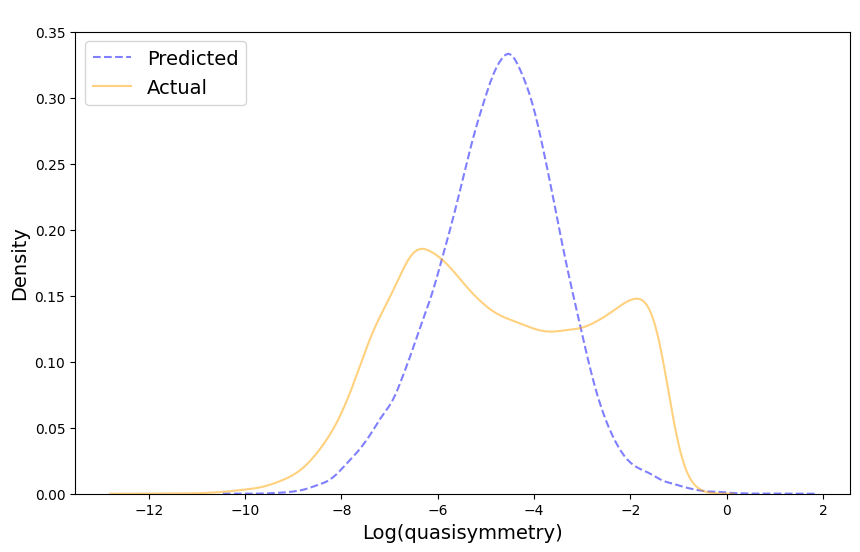

In [11]:
# Combine and plot
#df_combined = pd.concat([df_predictions, df_actual])
print(predictions.shape)
print(test_target_no_outliers.shape)

plt.figure(figsize=(10, 6))
sns.kdeplot(predictions, fill=False, color="blue", alpha=0.5, label="Predicted", linestyle='--')
sns.kdeplot(test_target_no_outliers, fill=False, color="orange", alpha=0.5, label="Actual")
plt.title('  ')
plt.xlabel('Log(quasisymmetry)', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.legend(loc='upper left', fontsize= 14)
plt.savefig('actual_vs_predictedpdf.pdf')  
plt.show()

In [9]:
import lightgbm as lgb

# Load the model
model = lgb.Booster(model_file='lightgbm_25_iter.txt')

# Assuming 'new_data' is your new dataset
predictions = model.predict(test_features_no_outliers)

# Use the predictions as needed
print(predictions)


[-2.45403465 -5.38197027 -4.31217236 ... -4.8251803  -4.5823923
 -5.07798997]


(47770,)
(47770,)


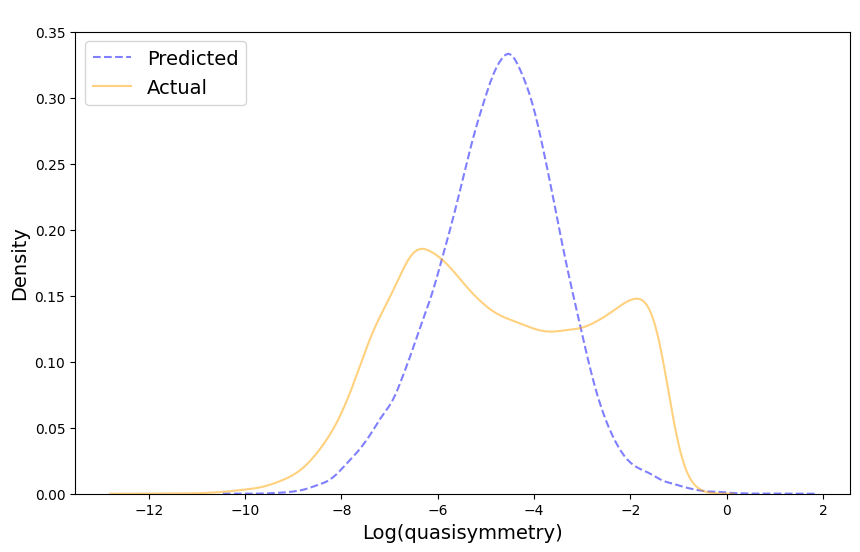

In [13]:
# Combine and plot
#df_combined = pd.concat([df_predictions, df_actual])
print(predictions.shape)
print(test_target_no_outliers.shape)

plt.figure(figsize=(10, 6))
sns.kdeplot(predictions, fill=False, color="blue", alpha=0.5, label="Predicted", linestyle='--')
sns.kdeplot(test_target_no_outliers, fill=False, color="orange", alpha=0.5, label="Actual")
plt.title('  ')
plt.xlabel('Log(quasisymmetry)', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.legend(loc='upper left', fontsize= 14)
plt.savefig('actual_vs_predictedpdf.pdf')  
plt.show()